<a href="https://colab.research.google.com/github/vvshankar78/EVA4.0-Assignment-6/blob/master/EVA4_Assign6d_L1%26L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


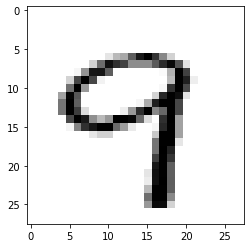

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

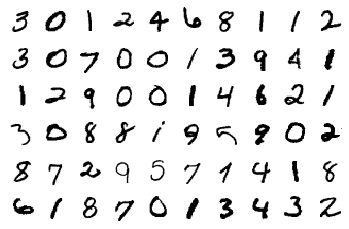

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        ) # output_size = 3

        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        # self.convblock11 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        #     #nn.ReLU() 
        # ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )
    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,440
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             160
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []                     
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # calculate Regularization
    wd = 1e-4
    #L1 Loss
    w1 = 0.
    for p in model.parameters(): w1 += torch.sum(abs(p)) 

    # L2 Loss
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()

    # # Rohan's code
    # w3 = 0.
    # l1_crit = nn.L1Loss(reduce=False)
    # for p in model.parameters(): w3+=l1_crit(p)


    # Calculate loss
    #loss = F.nll_loss(y_pred, target) + w1*wd
    loss = F.nll_loss(y_pred, target) + wd*(w1+w2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.179336279630661 Batch_id=468 Accuracy=93.67: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9850/10000 (98.50%)

EPOCH: 1


Loss=0.14620111882686615 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


Loss=0.18445664644241333 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.12223909795284271 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 37.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.17429953813552856 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.11884517967700958 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.12199892103672028 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.1769547462463379 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 37.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.09147953987121582 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.13792476058006287 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.07866805791854858 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.10650092363357544 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 37.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.08729642629623413 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 38.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.08363375067710876 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.0843476876616478 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.07184776663780212 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 38.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9908/10000 (99.08%)

EPOCH: 16


Loss=0.1302870213985443 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.08584848791360855 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 37.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9914/10000 (99.14%)

EPOCH: 18


Loss=0.11792787164449692 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.066823311150074 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9921/10000 (99.21%)

EPOCH: 20


Loss=0.08967418968677521 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 36.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9916/10000 (99.16%)

EPOCH: 21


Loss=0.16245566308498383 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 38.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.06432837247848511 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9909/10000 (99.09%)

EPOCH: 23


Loss=0.10709184408187866 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.11272929608821869 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.06236382573843002 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)

EPOCH: 26


Loss=0.07425645738840103 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9918/10000 (99.18%)

EPOCH: 27


Loss=0.062212955206632614 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.08632688224315643 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 37.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9922/10000 (99.22%)

EPOCH: 29


Loss=0.07617109268903732 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.13%)

EPOCH: 30


Loss=0.09319351613521576 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 31


Loss=0.08127705752849579 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 32


Loss=0.11343391239643097 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 33


Loss=0.08893869817256927 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9916/10000 (99.16%)

EPOCH: 34


Loss=0.07526249438524246 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9932/10000 (99.32%)

EPOCH: 35


Loss=0.06872528046369553 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 37.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9934/10000 (99.34%)

EPOCH: 36


Loss=0.06939017027616501 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.05965198576450348 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9914/10000 (99.14%)

EPOCH: 38


Loss=0.06587085872888565 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 39


Loss=0.07046426832675934 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]



Test set: Average loss: 0.0288, Accuracy: 9919/10000 (99.19%)



Text(0.5, 1.0, 'Test Accuracy')

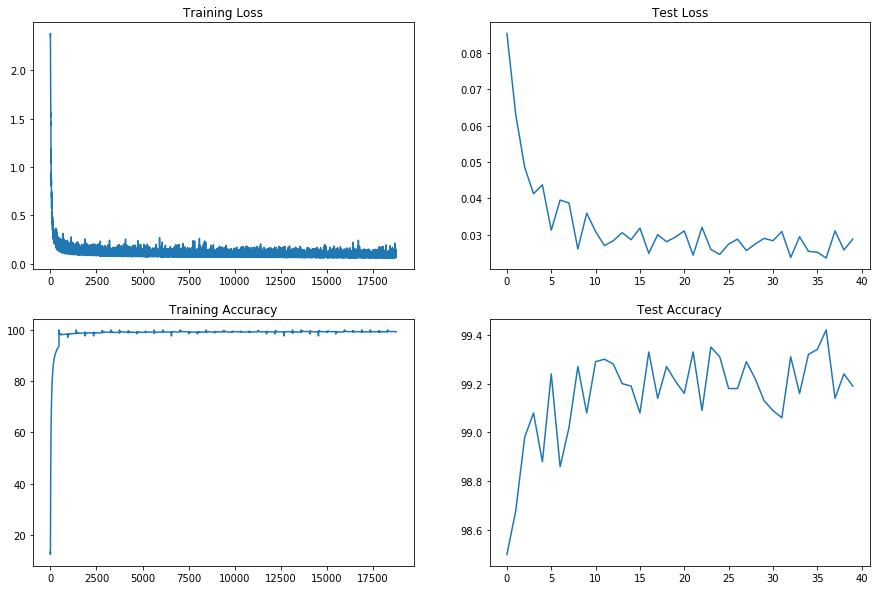

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=10000, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [15]:
model.eval();

correct = 0
with torch.no_grad():
  for data,target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = (output.argmax(dim=1, keepdim=True)).cpu()
    print(data.shape)
    print(output.shape)
    print(target.shape)
    



torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])
torch.Size([10000])


# of misclassified images :  81


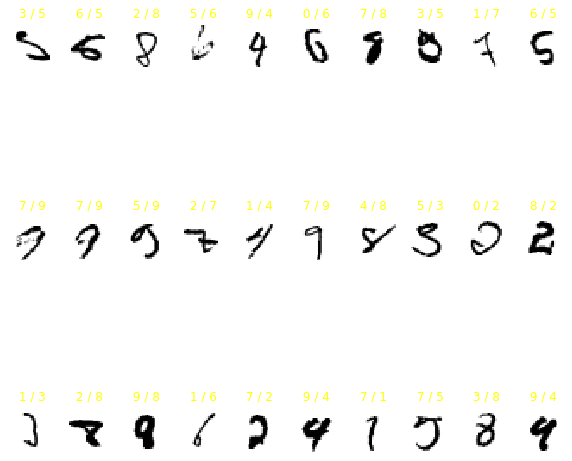

In [16]:

pred_ic = pred.cpu().numpy()
target_ic = target.view_as(pred).cpu().numpy()
data_ic =  data.cpu().numpy()

#print(pred_ic.shape, target_ic.shape, data_ic.shape)

test_incorrect = []
for i in range(10000):
  if pred_ic[i] != target_ic[i]:
    test_incorrect.append(i)

#print(test_incorrect[0:5])
print("# of misclassified images : ", len(test_incorrect))

figure = plt.figure(figsize=(10,10))
num_of_images = 30
for index in range(1, num_of_images+1):
  plt.subplot(3,10,index)
  plt.axis('off')
  plt.title(" %d / %d" % (pred_ic[test_incorrect[index]],target_ic[test_incorrect[index]]), color='yellow')
  plt.imshow(data_ic[test_incorrect[index]].squeeze(),cmap='gray_r')
